In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [94]:
from keras import backend as K
K.clear_session()

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt

## 1. Data Prep

In [104]:
#Get all the filenames
data_dir = 'D:\MSc2\Deep Learning Keras\Task8\Fruits'
folder_name = os.listdir(data_dir) #list of folder names
fnames = []

for i in range(len(folder_name)):
    folder_dir = os.path.join(data_dir, folder_name[i])
    fnames = fnames + [os.path.join(folder_dir, file_name) for file_name in os.listdir(folder_dir)]

In [105]:
n = len(fnames)
n

20622

In [46]:
#Create the Data Matrix 
data = np.empty([n,50,50,3], dtype=float) 
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(50,50))
    x = image.img_to_array(img)
    data[i,:,:,:] = x

In [47]:
data.shape

(20622, 50, 50, 3)

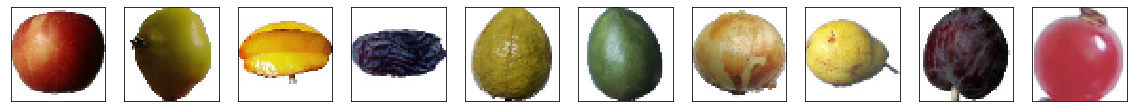

In [48]:
#Sample images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    index = [j for j in range(0,20000,2000)]
    img_path = fnames[index[i]]
    img = image.load_img(img_path, target_size=(50, 50))
       
    # display original
    ax = plt.subplot(1,10, i + 1)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
plt.show()

In [49]:
#Normalize the data to [0,1] - Each pixel/channel has a value b/t [0,255]
data = data / 255.

In [50]:
data.mean(), data.std()

(0.5944996194558401, 0.36139938592996335)

In [51]:
#Train-Test split
x_train = data[:8000,:,:,:]
x_test = data[8000:10000,:,:,:]
x_train.shape, x_test.shape

((8000, 50, 50, 3), (2000, 50, 50, 3))

## 2. Shallow autoencoder - single dense layer

In [19]:
#Encoder = single fully-connected neural layer
#Decoder = single fully-connected neural layer

#The representations were only constrained by the size of the hidden layer (1024) - to have compact representations (bottleneck)
#The hidden layer is learning an approximation of PCA (note the activations are not linear functions)

In [52]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 128 # 128 floats -> compression of factor 7500/128 = 58.6, the input has 50*50*3 = 7500 dimensions
                     #encoded dim of 1024
input_dim = 50*50*3

input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder1 = Model(input_img, decoded)

In [53]:
#Configure the Autoencoder - per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy') 
autoencoder1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 7500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               960128    
_________________________________________________________________
dense_6 (Dense)              (None, 7500)              967500    
Total params: 1,927,628
Trainable params: 1,927,628
Non-trainable params: 0
_________________________________________________________________


In [54]:
#Flatten the input images - for MLP
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train.shape, x_test.shape

((8000, 7500), (2000, 7500))

In [ ]:
#Train the Autoencoder 
##Note: Self-supervised learning, a specific instance of supervised learning where the targets
##are generated from the input data (here, y = x)
history1 = autoencoder1.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

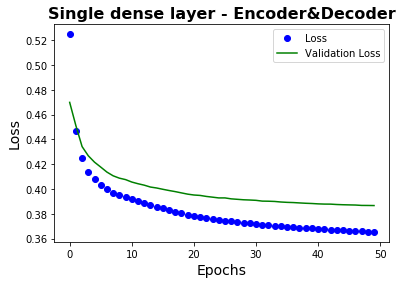

In [56]:
#Validation loss gets stable around 0.40
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Single dense layer - Encoder&Decoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [58]:
autoencoder1.evaluate(x_test,x_test)

2000/2000 [==============================] - 1s 448us/step


0.38661784934997556

In [59]:
#Predictions from the model
predictions = autoencoder1.predict(x_test)

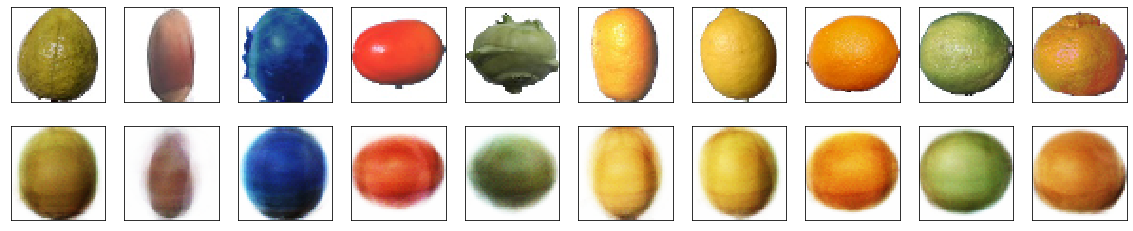

In [63]:
#Compare the original & reconstructed images 
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    index = [j for j in range(0,2000,200)]
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index[i]].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[index[i]].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Deep Autoencoder 

In [64]:
input_img = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded) #encoded to a latent space of dimension 128

decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder2 = Model(input_img, decoded)

In [65]:
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7500)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               3840512   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 7500)              3847500   
Total para

In [ ]:
history2 = autoencoder2.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

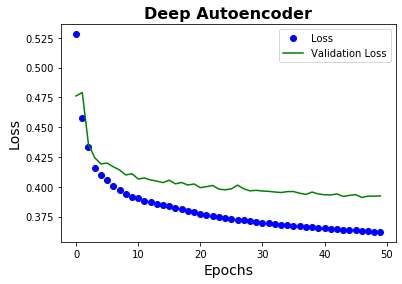

In [67]:
#Validation loss gets stable around 0.45
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Deep Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [68]:
autoencoder2.evaluate(x_test,x_test)

2000/2000 [==============================] - 2s 870us/step


0.39237532472610476

In [69]:
#Predictions from the model
predictions = autoencoder2.predict(x_test)

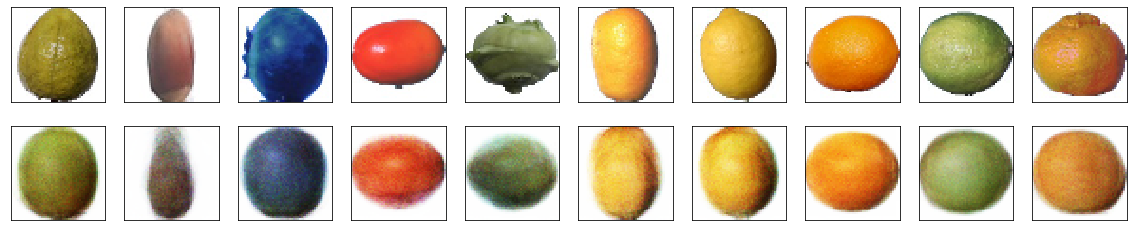

In [70]:
#Compare the original & reconstructed images 
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    index = [j for j in range(0,2000,200)]
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index[i]].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[index[i]].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 3. Convolutional Autoencoder

In [72]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

In [82]:
input_img = Input(shape=(48, 48, 3))  

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (12, 12, 64) - encoded dim = 9216 (very high entropic capacity)
#but even higher than the original image dim!! - not useful

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 24, 24, 64)        0         
__________

In [78]:
#Create the Data Matrix 
n = len(fnames)
data = np.empty([n,48,48,3], dtype=float) 
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(48,48))
    x = image.img_to_array(img)
    data[i,:,:,:] = x

In [79]:
#Normalize the data to [0,1] - Each pixel/channel has a value b/t [0,255]
data = data / 255.

In [81]:
#Train-Test split
x_train = data[:8000,:,:,:]
x_test = data[8000:10000,:,:,:]
x_train.shape, x_test.shape

((8000, 48, 48, 3), (2000, 48, 48, 3))

In [ ]:
#Similar results as the previous two
history3 = autoencoder3.fit(x_train, x_train, 
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

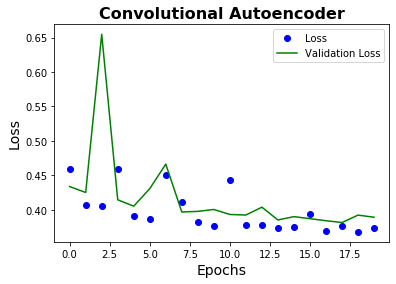

In [86]:
#Validation loss gets stable around 0.57
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Convolutional Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [87]:
autoencoder3.evaluate(x_test,x_test)

2000/2000 [==============================] - 17s 8ms/step


0.3893162176609039

In [90]:
#Predictions from the model
predictions = autoencoder3.predict(x_test)

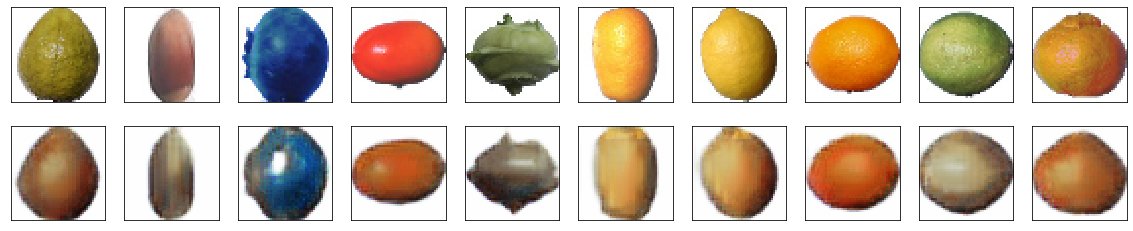

In [91]:
#Compare the original & reconstructed images 
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    index = [j for j in range(0,2000,200)]
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index[i]].reshape(48,48,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[index[i]].reshape(48,48,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 4. Variational Autoencoder

In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

In [106]:
#Create the Data Matrix 
data = np.empty([n,50,50,3], dtype=float) 
for i in range(0,len(fnames)-1):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(50,50))
    x = image.img_to_array(img)
    data[i,:,:,:] = x

In [107]:
#Normalize the data to [0,1] - Each pixel/channel has a value b/t [0,255]
data = data / 255.

In [108]:
#Train-Test split
x_train = data[:8000,:,:,:]
x_test = data[8000:10000,:,:,:]
x_train.shape, x_test.shape

((8000, 50, 50, 3), (2000, 50, 50, 3))

In [192]:
#1. Encoder
img_shape = (50, 50, 3)
latent_dim = 2  # Dimensionality of the latent space: a plane
input_img = Input(shape=(50, 50, 3))  

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x) #(None, 50, 50, 64) - 160000 dims

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mean = Dense(latent_dim)(x) #learning parameters
z_log_var = Dense(latent_dim)(x)

In [193]:
#2. Sampling from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.) #Standard Normal Distribution
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var]) #sampled points from the latent space

In [194]:
#3. Decoder
# This is the input where we will feed `z`.
decoder_input = Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(3, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [195]:
#4. Loss function
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded) #Reconstruction loss - Binary CE b/t x and xhat
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #Regularization loss - KL div b/t prior and latent
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [196]:
vae = Model(input_img, y)
vae.compile(optimizer='adadelta', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 50, 50, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 25, 25, 64)   18496       conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 25, 25, 64)   36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_33 

In [ ]:
#Similar results as the previous two
history_vae = vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=50,
        batch_size=64,
        validation_data=(x_test, None))

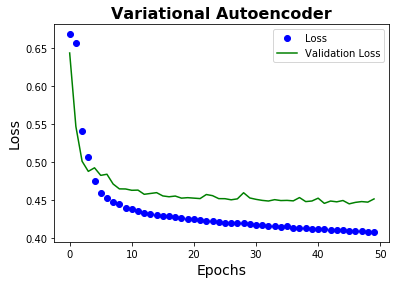

In [199]:
#Validation loss gets stable around 0.57
loss = history_vae.history['loss']
val_loss = history_vae.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.title('Variational Autoencoder', fontsize = 16, fontweight = 'bold')
plt.legend()

In [200]:
vae.evaluate(x_test,None)

2000/2000 [==============================] - 17s 9ms/step


0.4514096877574921

In [201]:
vae.save('vae.h5')

In [253]:
##Visulize the generated images
##Scan the latent plane, sampling latent points at regular intervals, 
##and generating the corresponding image for each of these points (z -> x). 

##This gives us a visualization of the latent manifold that "generates" the images.

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n1 = 10  
n2 = 10
batch_size=64

# Linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.8, 0.9, n1)) #(n1,) - INVERSE CDF OF N(0,1)
grid_y = norm.ppf(np.linspace(0.8, 0.9, n2)) #(n2,)

x_gen = np.empty([n1*n2,50,50,3], dtype=float) #(n1*n2, 100, 100, 3)
     
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0] 
        x_gen[i,:,:,:] = img

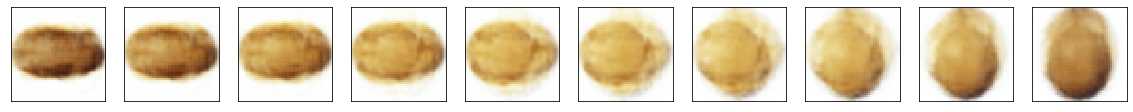

In [250]:
#Compare the original & reconstructed images - 0.1-0.9
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1):    
    ax = plt.subplot(1, n1, i + 1)
    plt.imshow(x_gen[i].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

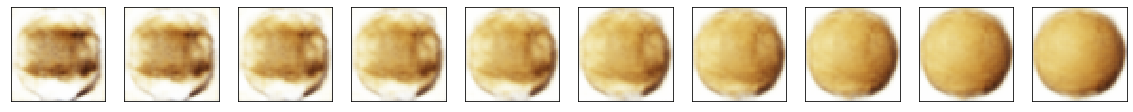

In [246]:
#Compare the original & reconstructed images - 0.1-0.5
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1):    
    ax = plt.subplot(1, n1, i + 1)
    plt.imshow(x_gen[i].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

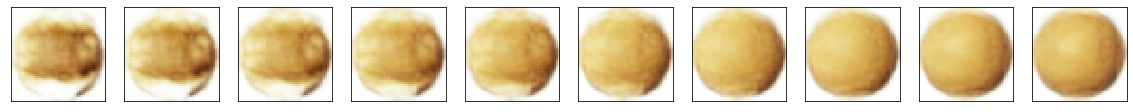

In [248]:
#Compare the original & reconstructed images - 0.2-0.6
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1):    
    ax = plt.subplot(1, n1, i + 1)
    plt.imshow(x_gen[i].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

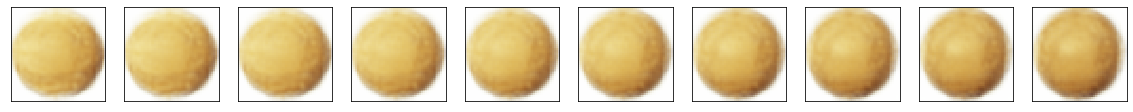

In [252]:
#Compare the original & reconstructed images - 0.5-0.7
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1):    
    ax = plt.subplot(1, n1, i + 1)
    plt.imshow(x_gen[i].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

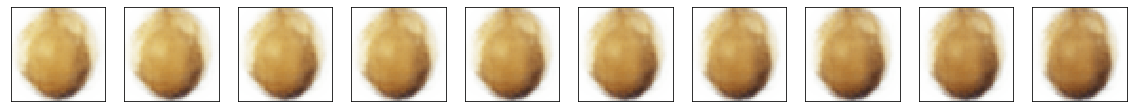

In [254]:
#Compare the original & reconstructed images - 0.8-0.9
plt.figure(figsize=(n2*2, n1*2))

for i in range(n1):    
    ax = plt.subplot(1, n1, i + 1)
    plt.imshow(x_gen[i].reshape(50,50,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()